In [178]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
import seaborn as sns
import pandas as pd
import umap
from scipy.spatial.distance import cdist
from tqdm import tqdm

import os

from src.models import LinearDecoder
from src.utils import ratemap_collage, SimpleDatasetMaker, get_ratemaps

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
figure_path = os.path.join(os.getcwd(), "figures")
model_path = os.path.join(os.getcwd(), "models")
results_path = os.path.join(os.getcwd(), "results")

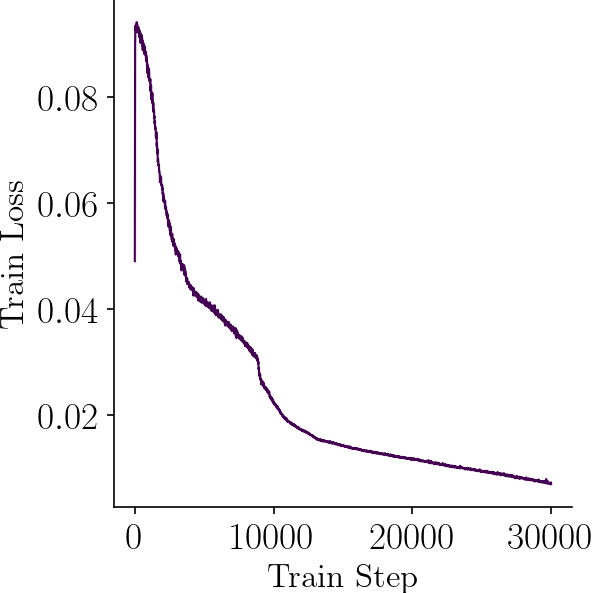

In [307]:
# Load models and loss histories
models, loss_histories = {}, {}
models["long_trajectory_rnn"] = [torch.load(os.path.join(model_path, f"long_trajectory_rnn_0.pt"))]
loss_histories["long_trajectory_rnn"] = [np.load(os.path.join(model_path, f"long_trajectory_rnn_0_loss_history.npy"))]

model_name_map = {
    "long_trajectory_rnn": "long trajectory"
}
        
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 0.5, len(models))]

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    # ax.semilogy(np.arange(len(loss_history[0])) * 10, np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.plot(np.arange(len(loss_history[0])) * 10, np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.fill_between(np.arange(len(loss_history[0])) * 10, np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
# ax.legend()
plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_long_traj_loss.svg'), transparent=True)

In [308]:
model = models["long_trajectory_rnn"][0]

ratemaps = get_ratemaps(model, bins=16, timesteps=20000, n_traj=1, intialization="constant", dataset_kwargs={"rayleigh_scale": 0.1})

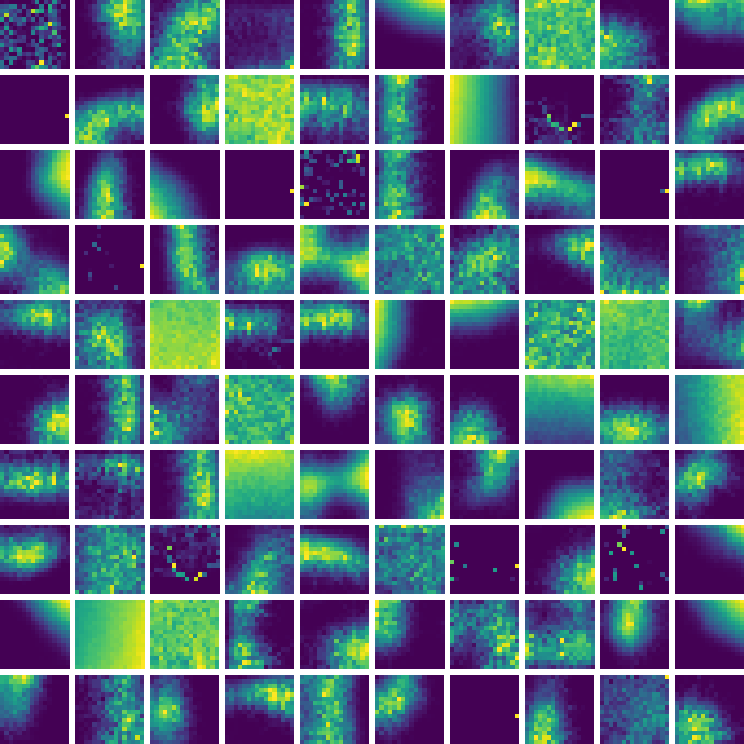

In [309]:
plt_ratemaps = ratemaps[np.nanmean(ratemaps, axis=(1, 2)) > 0.0]
fig, ax = ratemap_collage(plt_ratemaps[:100], cols=10, cmap="viridis", vmin=0)
plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_long_trajectory_ratemaps.svg'), transparent=True)

In [313]:
pos_name = "center"
scale = 0.25
n = 16
beta = 0.5

positions = {
    'center': [8, 8],
    'corner': [0, 0],
    'bottom': [4, 8]
}

pos = positions[pos_name]

ratemaps = get_ratemaps(model, bins=n, timesteps=20000, n_traj=1, intialization="constant", dataset_kwargs={"rayleigh_scale": 0.1})

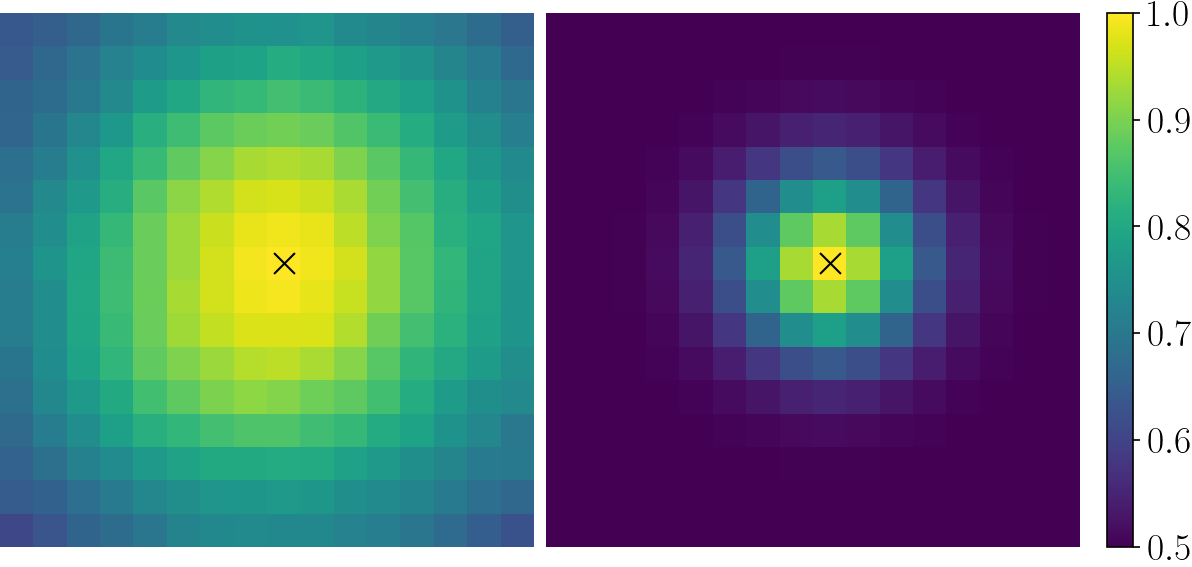

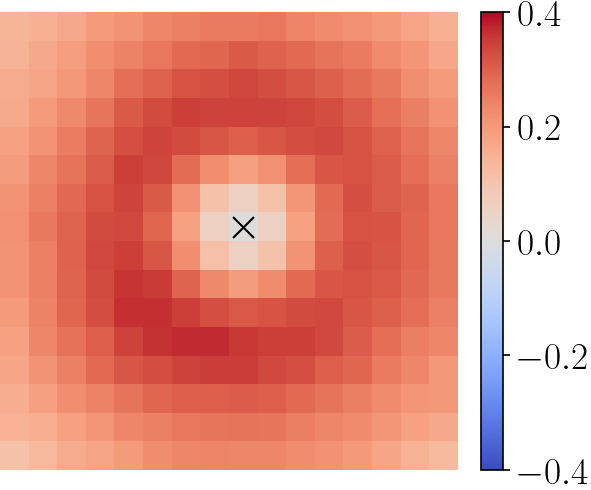

In [314]:
p = ratemaps.reshape(model.n_out, -1).T 

x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)
grid_corr = (1 - beta) * grid_corr + beta

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)
plt.show()

fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_{pos_name}_long_trajectory.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(4, 4))
im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.4, vmax=0.4)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)
plt.show()

fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_error_{pos_name}_long_trajectory.svg'), transparent=True)

In [368]:
train_steps = 30000         # Number of training steps
bs = 64                     # Batch size
t_train = 2000                # Number of training timesteps
lr = 1e-3                   # Learning rate

decoder = LinearDecoder(n_in=model.n_out, n_out=2)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
genny = SimpleDatasetMaker(rayleigh_scale=0.1)

r, v = genny.generate_dataset(1, 2000)
p = model.spatial_representation(v, model.initial_state(r[:, 0].shape[0]))[0].detach()
p = torch.reshape(p, (-1, p.shape[-1]))
r_label = r[:,1:].reshape(-1, 2)


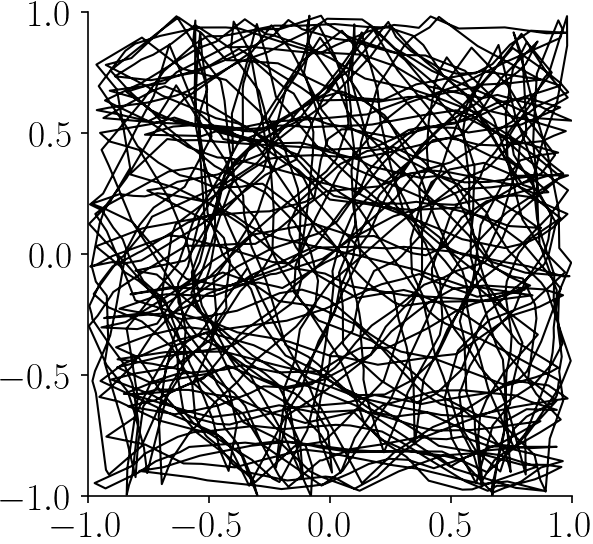

In [369]:
# Plit trajectory
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(r_label[:, 0], r_label[:, 1], color="black", lw=1)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")

loss: 0.000681: 100%|██████████| 30000/30000 [00:07<00:00, 4175.81it/s]


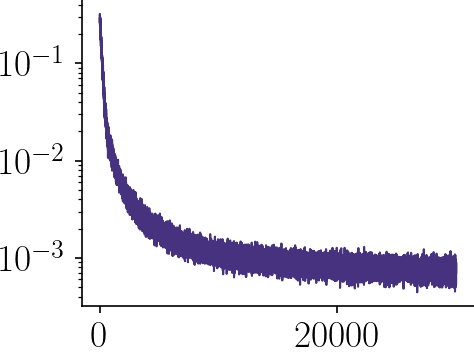

In [370]:
# Train on first X timesteps
p_train = p[50:t_train]                 # Ignore first 50 timesteps
r_label_train = r_label[50:t_train]

decoder_history = []
progress = tqdm(range(train_steps))
for i in progress:
    
    idx = np.random.choice(np.arange(p_train.shape[0]), bs) 
    loss = decoder.train_step(x=p_train[idx], y=r_label_train[idx], optimizer=optimizer)

    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")
    
    decoder_history.append(loss)

plt.plot(decoder_history)
plt.yscale("log")
plt.show()

In [371]:
t_eval = 500

r, v = genny.generate_dataset(1, t_eval)
p = model.spatial_representation(v, model.initial_state(r[:, 0].shape[0]))[0].detach()
p_eval = torch.reshape(p, (-1, p.shape[-1]))
r_label_eval = r[:, 1:].reshape(-1, 2).detach().numpy()

# Evaluate from 500 to 1000 timesteps
# p_eval = p[t_train:]
# r_label_eval = r_label[t_train:].detach().numpy()


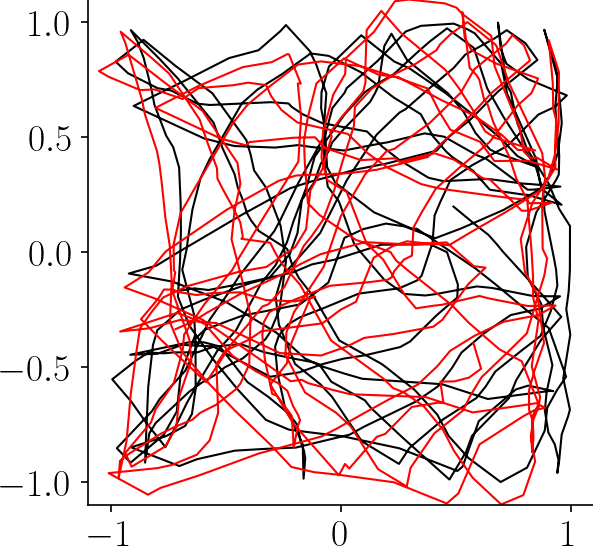

In [372]:
r_pred = decoder(p_eval).detach().numpy()

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(r_label_eval[:, 0], r_label_eval[:, 1], label="True", color="black", lw=1)
ax.plot(r_pred[:, 0], r_pred[:, 1], label="Predicted", color="red", lw=1)
# ax.legend()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_long_trajectory_decoder.svg'), transparent=True)


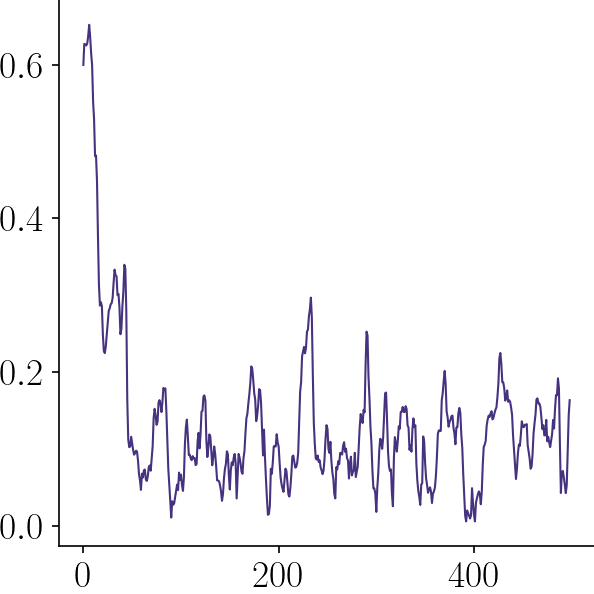

In [373]:
ld_error = np.linalg.norm(r_pred - r_label_eval, axis=-1)
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(ld_error)
plt.show()

In [374]:
def population_decoding(p, memory, r_memory):
    """Population decoding scheme: decode location as location r_memory
       corresponding to most similar (closest) population vector in memory
       to current population vector p

    Args:
        p (N, n_p): population vectors to be decoded
        memory (M, n_p): memory of population vectors
        r_memory (M, 2): physical locations of memory vectors
    """
    dists = np.sum((p[None] - memory[:,None])**2, axis = -1) # (M, N)
    inds = np.argmin(dists, axis = 0) # (N)
    decoded_trajectories = r_memory[inds] #(N, 2)
    return decoded_trajectories


In [375]:
res = 32        # Defines the memory resolution

# Create ratemaps based on the training data
ps = p_train.reshape(-1, p.shape[-1])
rs = r_label_train.detach().numpy()
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:, 0], rs[:, 1], ps.T, bins=res)       
ratemaps = np.nan_to_num(ratemaps, nan=0.0)     # Replace NaNs with 0s

# Form memories
memory = ratemaps.reshape(model.n_out, -1).T
x = np.linspace(-1, 1, res+1)
y = x.copy()
xx = x[:-1] + np.diff(x) / 2
yy = y[:-1] + np.diff(y) / 2
xx, yy = np.meshgrid(xx,yy)
r_memory = np.stack((yy.ravel(), xx.ravel()), axis =-1)             # (Square) grid of memory locations

# Get decoded positions
r_decoded = population_decoding(p_eval.detach().numpy(), memory, r_memory)

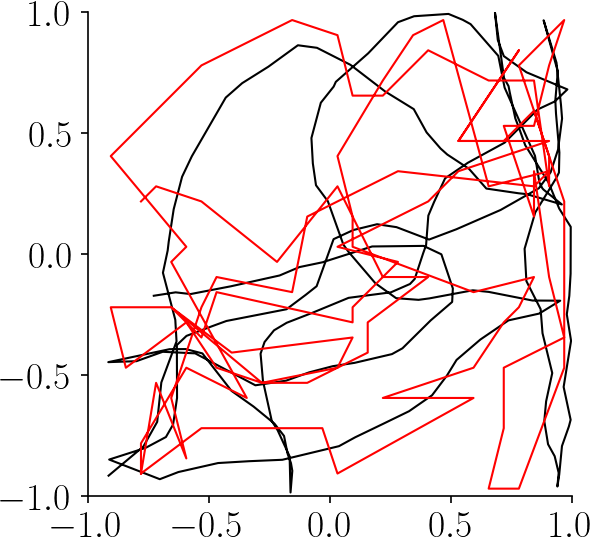

In [376]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(r_label_eval[300:, 0], r_label_eval[300:, 1], label="True", color="black", lw=1)
ax.plot(r_decoded[300:, 0], r_decoded[300:, 1], label="Decoded", color="red", lw=1)

# ax.plot(r_label_eval[:, 0], r_label_eval[:, 1], label="True", color="black", lw=1)
# ax.plot(r_decoded[:, 0], r_decoded[:, 1], label="Decoded", color="red", lw=1)
# ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")

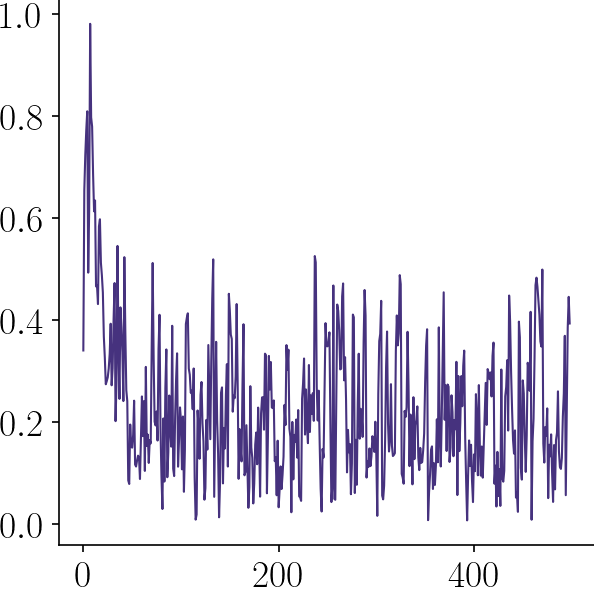

In [377]:
# Plot error
pop_error = np.linalg.norm(r_decoded - r_label_eval, axis=-1)
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(pop_error)
plt.show()


In [378]:
naive_error = np.linalg.norm(r_label_eval - np.zeros_like(r_label_eval), axis=-1).mean()

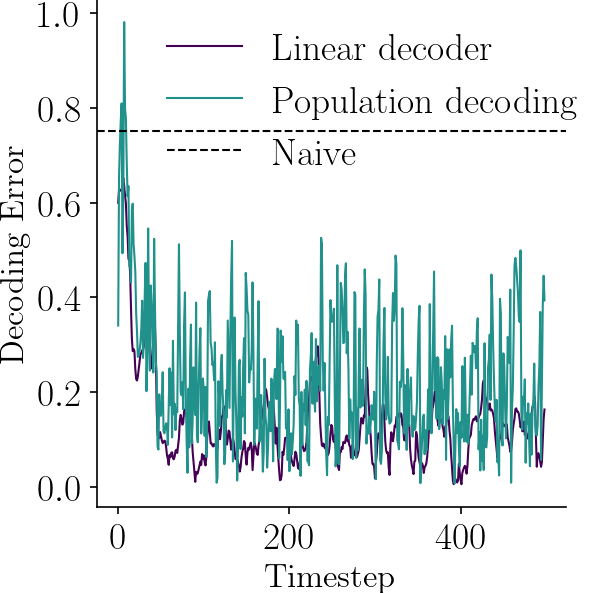

In [379]:
colors = plt.cm.viridis(np.linspace(0, 0.5, 2))

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(ld_error, label="Linear decoder", color=colors[0])
ax.plot(pop_error, label="Population decoding", color=colors[1])
ax.axhline(naive_error, color="black", linestyle="--", label="Naive")
ax.set_xlabel("Timestep")
ax.set_ylabel("Decoding Error")
# Place legend outside of plot
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_long_trajectory_decoding_error_legend.svg'), transparent=True)